## Analysing CSI data for a reliable "Activity Indicator" metric

In [37]:
import sys

sys.path.insert(0, "..")

import scipy.io
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from HAR.transformers import CSIScaler

sns.set_theme()


def load_dataset(infile):
    mat = scipy.io.loadmat(infile)
    X = mat["csi"].T
    nsamples = mat["nsamples"].flatten()
    dim = mat["dim"].flatten()
    classnames = list(map(lambda s: s.strip().title(), mat["classnames"]))
    y = []
    for i in range(len(classnames)):
        y += [i] * nsamples[i]
    y = np.array(y)
    return X, y, nsamples, classnames, dim

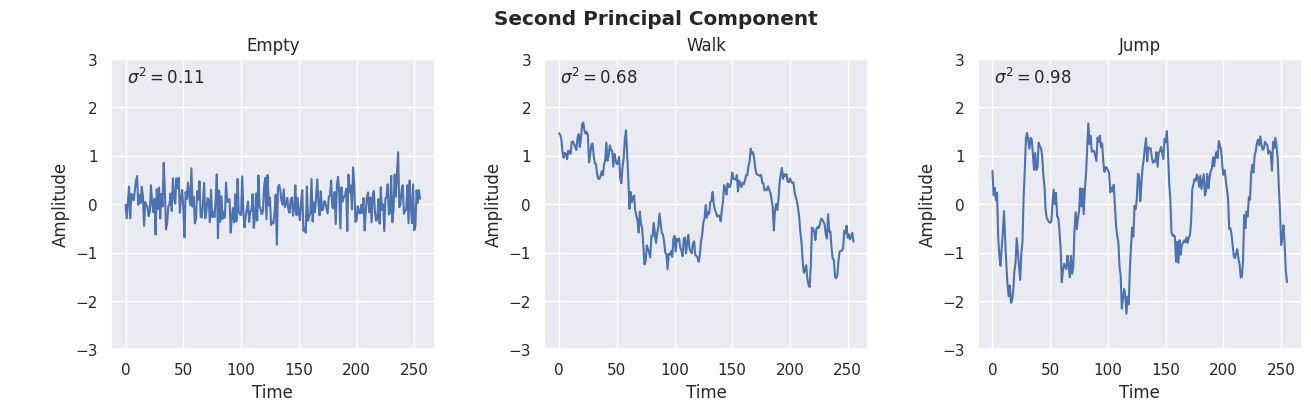

In [38]:
X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-5.mat")
X = X.reshape(X.shape[0], *dim)
scaler = CSIScaler()

rng = np.random.default_rng(seed=8)

plt.figure(figsize=(13, 4), constrained_layout=True)
for i in range(len(classnames)):
    isample = nsamples[:i].sum() + rng.integers(0, nsamples[i])
    sample = X[isample, :, :]
    sample = scaler.fit_transform(sample.reshape(1, *sample.shape))

    U, _, _ = np.linalg.svd(sample[0])
    s = np.dot(U[:, 1], sample[0])

    plt.subplot(1, 3, i + 1)
    plt.plot(s)
    plt.ylim([-3, 3])
    plt.title(classnames[i].title())
    plt.text(1, 2.5, rf"$\sigma^2 = ${np.var(s):0.2f}")
    plt.xlabel("Time")
    plt.ylabel("\n\nAmplitude")

plt.suptitle("Second Principal Component", fontweight="bold")
plt.show()

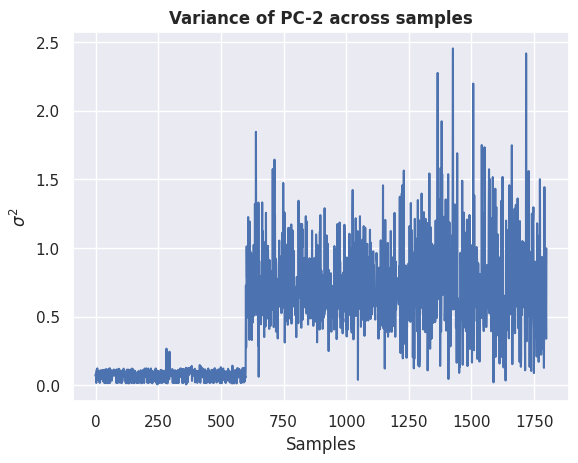

In [40]:
def compute_var(x):
    x = scaler.fit_transform(x.reshape(1, *dim))
    U, _, _ = np.linalg.svd(x[0, :, :])

    return np.var(np.dot(U[:, 1], x[0, :, :]))


var = np.apply_along_axis(
    compute_var, arr=X.reshape(X.shape[0], dim[0] * dim[1]), axis=1
)

plt.plot(var)
plt.xlabel("Samples")
plt.ylabel(r"$\sigma^2$")
plt.title("Variance of PC-2 across samples", fontweight="bold")
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import fmin

y_actual = y.copy()
y_actual[y_actual != 0] = 1


def loss(th):
    y_pred = np.zeros_like(var)
    y_pred[var > th] = 1
    return 1 - accuracy_score(y_actual, y_pred)


th_opt = fmin(loss, np.array([0.1]))[0]

print("Optimal threshold:", th_opt)
y_pred = np.zeros_like(var)
y_pred[var > th_opt] = 1

print("\n> Accuracy score")
print(accuracy_score(y_actual, y_pred))
print("\n> Confusion matrix")
print(confusion_matrix(y_actual, y_pred))

Optimization terminated successfully.
         Current function value: 0.012222
         Iterations: 12
         Function evaluations: 29
Optimal threshold: 0.13250000000000012

> Accuracy score
0.9877777777777778

> Confusion matrix
[[ 593    7]
 [  15 1185]]
